In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ppr.robot import Robot, Robot_3R, Robot_2P3R
from ppr.path import TrajectoryPt, TolerancedNumber
from ppr.geometry import Rectangle

In [2]:
# ROBOT
robot1 = Robot_2P3R([1, 1, 2, 1.2, 1])
robot1.set_joint_limits([(0.5, 1.0), (2.0, 3.0)])
robot1.ik_samples = [3, 5]

# PATH
dx    = TolerancedNumber(0.5, 0.3, 0.8, samples=4)
dy    = np.linspace(2, 2.5, 5)
angle = TolerancedNumber(0.0, -np.pi, np.pi, samples=20)
path1 = [TrajectoryPt([dx, yi, angle]) for yi in dy]

# COLLISION SCENE
sc1 = [Rectangle(1, 1, 1, 1.5, 0),
       Rectangle(3, 1, 1, 2.2, 0),
       Rectangle(0, 3.2, 4, 0.5, 0),
       Rectangle(0, 1, 0.2, 3.2, 0),
       Rectangle(0.2, 1, 0.8, 0.5, 0)]

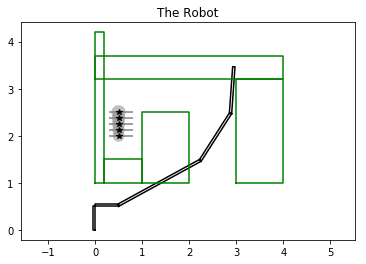

In [3]:
fig1, ax1 = plt.subplots()
plt.title("The Robot")
ax1.axis('equal')
robot1.plot(ax1, [0.5, 0.5, 0.5, 0.5, 0.5], 'k')
for tp in path1: tp.plot(ax1)
for r in sc1: r.plot(ax1, 'g')
plt.show()

In [4]:
from ppr.sampling import cart_to_joint
from ppr.sampling import get_shortest_path

In [5]:
path_js = cart_to_joint(robot1, path1, check_collision=True, scene=sc1)

In [6]:
print([len(qp) for qp in path_js])

[15, 25, 27, 42, 72]


In [7]:
sol = get_shortest_path(path_js)
print(sol['success'])

converting type of Q
[ 6 18  6 31 51]
True


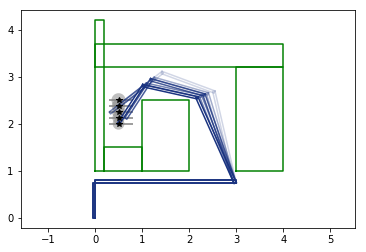

In [8]:
fig2, ax2 = plt.subplots()
ax2.axis('equal')
#robot1.plot_path_kinematics(ax2, path_js[2])
robot1.plot_path(ax2, sol['path'])
for r in sc1: r.plot(ax2, 'g')
for tp in path1: tp.plot(ax2)
plt.show()

In [9]:
from ppr.optim import get_optimal_trajectory

In [10]:
q_init = sol['path']
q_opt, _, _ = get_optimal_trajectory(robot1, path1, q_init, check_collision=True, scene=sc1)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1002417632.7870184
            Iterations: 80
            Function evaluations: 2494
            Gradient evaluations: 76


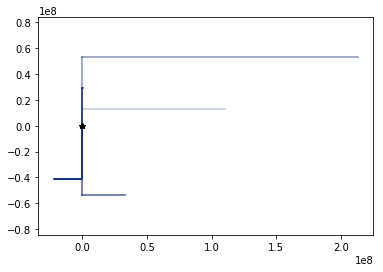

In [11]:
fig3, ax3 = plt.subplots()
ax3.axis('equal')
robot1.plot_path(ax3, q_opt)
for r in sc1: r.plot(ax3, 'g')
for tp in path1: tp.plot(ax3)
plt.show()